## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

In [258]:
#import essential libraries
import os
import cv2
import pickle
import numpy as np
import time
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook .  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:



([], <a list of 0 Text yticklabel objects>)

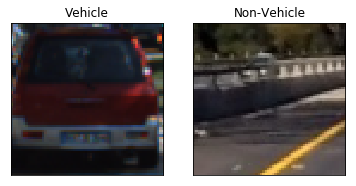

In [259]:
#plot the data set of vehicle and non vehicle.

plt.subplot(1,2,1)
vehicle = plt.imread('training_datas/vehicles/vehicles/KITTI_extracted/80.png')
plt.imshow(vehicle)
plt.title('Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
non_vehicle = plt.imread('training_datas/non-vehicles/non-vehicles/Extras/extra26.png')
plt.imshow(non_vehicle)
plt.title('Non-Vehicle')
plt.xticks([])
plt.yticks([])

#### HOG implementation and figures
I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

In [260]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

True

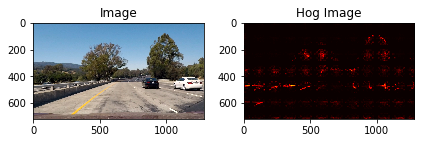

In [261]:
img = mpimg.imread('test_images/test1.jpg')

hls_img = convert_color(img, conv = 'HLS')

orient = 9
pix_per_cell= 8
cell_per_block= 2

features, hog_image = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='hot')
plt.title('Hog Image')
fig.tight_layout()

cv2.imwrite('output_images/hog_image1.jpg', hog_image)

In [262]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)    
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial1(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [263]:
def train_features(cars, notcars, color_space='YUV', 
                            spatial_size=(16,16), hist_bins=16, 
                            orient=9, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True):

    cars = cars[0:len(cars)-1]
    notcars = notcars[0:len(notcars)-1]

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    print('X_train shape', X_train.shape)
    print('X_test shape', X_test.shape)
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    accuracy_score = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', accuracy_score)
    return svc, X_scaler, accuracy_score

#### 2. Explain how you settled on your final choice of HOG parameters.
I tried varying the parameters like the one commented below and the improvised parameters is in the pipeline (uncommented).

In [264]:
# Tune the parameters here

#color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9  # HOG orientations  e.g.: 9
#pix_per_cell = 8 # HOG pixels per cell e.g: 8
#cell_per_block = 2 # HOG cells per block e.g: 2
#hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions e.g: (16,16)
#hist_bins = 16    # Number of histogram bins e.g: 16
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off
#y_start_stop = [None, None] # Min and max in y to search in slide_window()

color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True


#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using `sklearn`'s `LinearSVC()` for all `car` and `not-car` image features. I have used `YCrCb` colorspace with histogram orientation `9`, pixels per cell `8`, cells per block `2`.

In [265]:

# find_cars parameters
ystart = 400
ystop = 680
scale = 1.5


car_images = glob.glob('training_datas/vehicles/vehicles/*/*.png')
noncar_images = glob.glob('training_datas/non-vehicles/non-vehicles/*/*.png')
# No. of samples to consider for training
cars_sample_size = len(car_images)-1
not_cars_sample_size=len(noncar_images)-1

svc, X_scaler, accuracy_score = train_features(car_images, noncar_images, 
                            color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)


data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('model-params.pk', 'wb') as pFile:
    pickle.dump(data, pFile)  

X_train shape (14206, 8460)
X_test shape (3552, 8460)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
23.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


#### Store the parameters. 

In [267]:
import pickle 

## Load model params
with open('model-params.pk', 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data



#### 4. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?
A single function, find_cars is used to extract features using hog sub-sampling and make predictions. The hog sub-sampling helps to reduce calculation time for finding HOG features and thus provided higher throughput rate. A sample output from the same is shown below.

([], <a list of 0 Text yticklabel objects>)

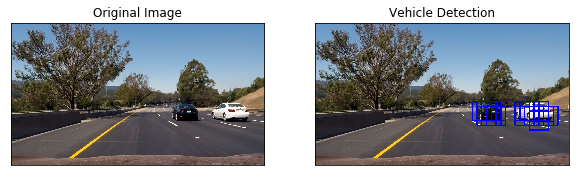

In [268]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return  cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return  cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
img = mpimg.imread('test_images/test6.jpg')

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(out_img)
plt.title('Vehicle Detection')
plt.xticks([])
plt.yticks([])


#### The scale for the multi-window search and overlap to be considered was decided emperically.

The multi-scale window approach prevents calculation of feature vectors for the complete image and hence speed up the process. 
The following scales were emperically decided each having a overlap of 75% (decided by cells_per_step which is set as 2):

Scale 1: [ystart = 380, ystop = 480, scale = 1]

Scale 2: [ystart = 400, ystop = 600, scale = 1.5]

Scale 3: [ystart = 500, ystop = 700, scale = 2.5]


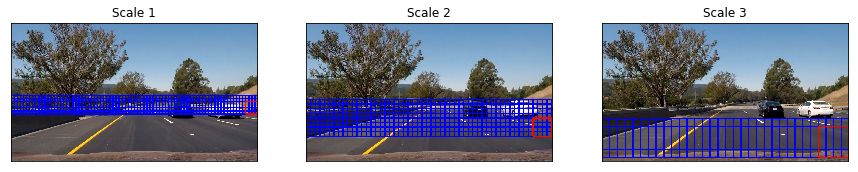

In [269]:
def draw_multi_scale_windows(img, ystart, ystop, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    imshape = img_tosearch.shape
    img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2

    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    rect_start = None
    rect_end = None
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            rect_start = (xbox_left, ytop_draw + ystart)
            rect_end = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            cv2.rectangle(draw_img, rect_start, rect_end, (0, 0, 255), 6)
    
    cv2.rectangle(draw_img, rect_start, rect_end, (255, 0, 0), 6)

    return draw_img

img = mpimg.imread('test_images/test6.jpg')

plt.figure(figsize=(15,40))
subpltcount=1
for (ystart, ystop, scale) in [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]:
    plt.subplot(1,3,subpltcount)
    plt.imshow(draw_multi_scale_windows(img, ystart, ystop, scale))
    plt.title('Scale %s'%subpltcount)
    plt.xticks([])
    plt.yticks([])
    subpltcount +=1

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?
Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  

Below, I have elegantly represented by a class which uses the saved data from the previous section and implements the pipeline which can be useable for video too. 


In [272]:
from scipy.ndimage.measurements import label

class VehicleDetector:
    def __init__(self, model_param_files):
        # Loading Model Parameters
        with open(model_param_files, 'rb') as pfile:
            pickle_data = pickle.load(pfile)
            for key in pickle_data:
                exec("self." + key + "= pickle_data['" + str(key) + "']")
            del pickle_data

        # Current HeatMap
        self.heatmap = None

        # Heat Image for the Last Three Frames
        self.heat_images = deque(maxlen=3)

        # Current Frame Count
        self.frame_count = 0
        self.full_frame_processing_interval = 10

        # Xstart
        self.xstart = 600

        # Various Scales
        self.ystart_ystop_scale = [(360, 560, 1.5), (400, 600, 1.8), (440, 700, 2.5)]

        # Kernal For Dilation
        self.kernel = np.ones((50, 50))

        # Threshold for Heatmap
        self.threshold = 2

    def find_cars(self, img):
        X_scaler = self.X_scaler
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        svc = self.svc

        box_list = []

        draw_img = np.copy(img)
        img = img.astype(np.float32) / 255

        if self.frame_count % self.full_frame_processing_interval == 0:
            mask = np.ones_like(img[:, :, 0])
        else:
            mask = np.sum(np.array(self.heat_images), axis=0)
            mask[(mask > 0)] = 1
            mask = cv2.dilate(mask, self.kernel, iterations=1)

        self.frame_count += 1

        for (ystart, ystop, scale) in self.ystart_ystop_scale:

            nonzero = mask.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            if len(nonzeroy) != 0:
                ystart = max(np.min(nonzeroy), ystart)
                ystop = min(np.max(nonzeroy), ystop)
            if len(nonzeroy) != 0:
                xstart = max(np.min(nonzerox), self.xstart)
                xstop = np.max(nonzerox)
            else:
                continue

            if xstop <= xstart or ystop <= ystart:
                continue

            img_tosearch = img[ystart:ystop, xstart:xstop, :]
            ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ys = np.int(imshape[1] / scale)
                xs = np.int(imshape[0] / scale)
                if (ys < 1 or xs < 1):
                    continue
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

            if ctrans_tosearch.shape[0] < 64 or ctrans_tosearch.shape[1] < 64:
                continue

            ch1 = ctrans_tosearch[:, :, 0]
            ch2 = ctrans_tosearch[:, :, 1]
            ch3 = ctrans_tosearch[:, :, 2]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // pix_per_cell) - 1
            nyblocks = (ch1.shape[0] // pix_per_cell) - 1
            nfeat_per_block = orient * cell_per_block ** 2
            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // pix_per_cell) - 1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step

            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

            for xb in range(nxsteps + 1):
                for yb in range(nysteps + 1):
                    ypos = yb * cells_per_step
                    xpos = xb * cells_per_step

                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos * pix_per_cell
                    ytop = ypos * pix_per_cell

                    # Extract the image patch
                    subimg = ctrans_tosearch[ytop:ytop + window, xleft:xleft + window]

                    # Get color features
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)

                    # Scale features and make a prediction
                    test_features = X_scaler.transform(
                        np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                    # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)
                    if test_prediction == 1:
                        xbox_left = xstart + np.int(xleft * scale)
                        ytop_draw = np.int(ytop * scale)
                        win_draw = np.int(window * scale)
                        box_list.append(
                            ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

        # Add heat to each box in box list
        self.add_heatmap_and_threshold(draw_img, box_list, self.threshold)

        # Find final boxes from heatmap using label function
        labels = label(self.heatmap)
        VehicleDetector.draw_labeled_bboxes(draw_img, labels)

        return draw_img

    def add_heatmap_and_threshold(self, draw_img, bbox_list, threshold):
        heatmap = np.zeros_like(draw_img[:, :, 0]).astype(np.float)

        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        self.heat_images.append(heatmap)
        self.heatmap = np.sum(np.array(self.heat_images), axis=0)
        self.heatmap[self.heatmap <= threshold] = 0

    @staticmethod
    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

1. The false positives were avoided by using wrongly classified examples and adding it to the training dataset.

2. Use of YCrCb color space, the number of false positives reduced (Tried with other color space but YcrCb was opmimum here).

3. I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

([], <a list of 0 Text yticklabel objects>)

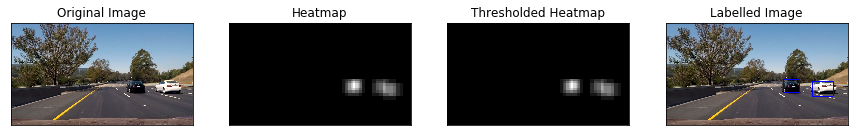

In [273]:
vehicleDetector = VehicleDetector('model-params.pk')
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 3


img = mpimg.imread('test_images/test6.jpg')
out = vehicleDetector.find_cars(img)


plt.figure(figsize=(15,40))

## Input Image
plt.subplot(141)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])


## Heatmap
plt.subplot(142)
heatmap = vehicleDetector.heat_images[0]
plt.imshow(heatmap, cmap='gray')
plt.title('Heatmap')
plt.xticks([])
plt.yticks([])

## Thresholded Heatmap
plt.subplot(143)
t_heatmap = vehicleDetector.heatmap
plt.imshow(heatmap, cmap='gray')
plt.title('Thresholded Heatmap')
plt.xticks([])
plt.yticks([])

## Label Detection
plt.subplot(144)
from scipy.ndimage.measurements import label
labels = label(t_heatmap)
labelled_image = np.copy(img)
VehicleDetector.draw_labeled_bboxes(labelled_image, labels)
plt.imshow(labelled_image)
plt.title('Labelled Image')
plt.xticks([])
plt.yticks([])

#### Below is the video pipeline and the resulting video from pipeline

In [275]:
vehicleDetector = VehicleDetector('model-params.pk')
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 3

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output_without_lanes.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(vehicleDetector.find_cars)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output_without_lanes.mp4
[MoviePy] Writing video project_video_output_without_lanes.mp4


100%|█████████▉| 1260/1261 [06:32<00:00,  3.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_without_lanes.mp4 

Wall time: 6min 33s


#### Limitations and future work
1. lighting conditions and occulutions are the cases where the algorithm fails to perform.
2. Further perfomance optimization can be done by the knowledge of previous frames and weighted average over the heap maps will improve the performance. 